In [12]:
%%capture nop
import os 
IS_KAGGLE = not not os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
if IS_KAGGLE:
    !git clone https://github.com/Janluke0/PoS-Tagging/
    os.chdir('PoS-Tagging')
    !pip install positional-encodings
else:
    os.chdir('..')

In [34]:
import model.transformer as trans
from dataset.tokenizer import get_tokenizer
import dataset.twtita as twita
import torch
import pytorch_lightning as pl

In [30]:
def mk_dataloaders(tknzr,
                   ds_names=['train', 'test'],
                   batch_size=64,
                   shuffle=True,
                   align_labels=True,
                   epad_subtokens=True,
                   add_final_pad=False):

    def transformer(tkns, tags):
        tokens = [" " + w if i > 0 else w for i, w in enumerate(list(tkns))]
        _, ids, _ = twita.tokenize(tknzr, tokens)
        ids = torch.tensor(ids)
        return ids, ids

    def word_tokenizer(w): return [w]

    dataloaders = []

    for name in ds_names:
        ds = twita.TWITADS(name, word_tokenizer,
                     transform=transformer)
        dataloaders.append(twita.DataLoader(ds, shuffle=shuffle,
                                      batch_size=batch_size, collate_fn=twita.collate_fn))
    return (ds.n_tags, *dataloaders)

def flatten(t):
    return [item for sublist in t for item in sublist]


In [14]:
tknzr = get_tokenizer('resampled_train', 'BPE')

c:\Users\gianl\Documents\university\tesi\PoS-Tagging\twitads\resampled_train.dat


In [23]:
model = trans.PLWrapper(trans.TokenizedSeq2Seq(
    tknzr.get_vocab_size(),
    256,
    tknzr.get_vocab_size(),
    nheads=4,
    dropout=0.1,
    n_encoder=2,
    n_decoder=2,
    src_pad_idx=0,tgt_pad_idx=0),
)
model

PLWrapper(
  (model): TokenizedSeq2Seq(
    (src_embedding): Sequential(
      (0): Embedding(2048, 256)
      (1): Summer(
        (penc): PositionalEncoding1D()
      )
    )
    (tgt_embedding): Sequential(
      (0): Embedding(2048, 256)
      (1): Summer(
        (penc): PositionalEncoding1D()
      )
    )
    (clf): Sequential(
      (0): Dropout(p=0.1, inplace=False)
      (1): Linear(in_features=256, out_features=2048, bias=True)
    )
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=1024, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps

In [33]:
_, dl_train, dl_val = mk_dataloaders(tknzr,ds_names=['resampled_train', 'resampled_validation'], batch_size=128)

c:\Users\gianl\Documents\university\tesi\PoS-Tagging\twitads\resampled_train.dat
c:\Users\gianl\Documents\university\tesi\PoS-Tagging\twitads\resampled_validation.dat


In [35]:
early_stopping = lambda: pl.callbacks.EarlyStopping(monitor='val_acc',min_delta=1e-6,mode='max',patience=40)
checkpoints = lambda: pl.callbacks.ModelCheckpoint(monitor='val_acc',mode='max')
trainer = pl.Trainer(log_every_n_steps=2,gpus=1, max_epochs=2000, callbacks=[early_stopping(), checkpoints()])
trainer.fit(model, dl_train, dl_val)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | TokenizedSeq2Seq | 5.3 M 
1 | val_acc     | PureAccuracy     | 0     
2 | val_raw_acc | Accuracy         | 0     
-------------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.049    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\gianl\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\gianl\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\gianl\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 23:  15%|█▍        | 15/101 [00:07<00:43,  1.98it/s, loss=0.026, v_num=0, val_acc=0.963, val_raw_acc=0.963]  

C:\Users\gianl\AppData\Local\Continuum\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


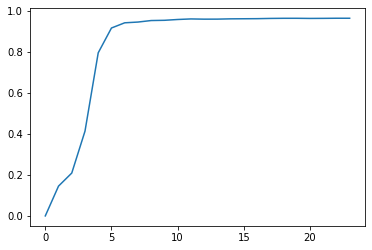

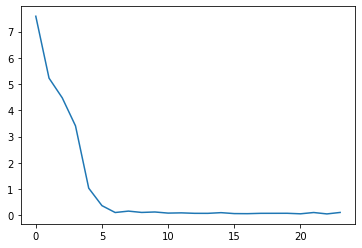

In [44]:
import matplotlib.pyplot as plt 
plt.plot(model.val_metrics['accuracy'])
plt.figure()
plt.plot(model.val_metrics['loss'])

In [45]:
@torch.no_grad()
def it_inference(self, begin):
    MAX_TGT_LEN = 100
    BOS_IDX = twita.TWITADS._TAGS['[BOS]']
    it_y = torch.zeros(1, MAX_TGT_LEN).long().cuda()
    it_y[:, 0:1] = BOS_IDX
    for i in range(1, MAX_TGT_LEN):
        pred = model(src, it_y).argmax(dim=-1)
        it_y[:, i:i + 1] = pred[:, i:i + 1]
        #if the last pred of every sentece is EOS exit
    return it_y[:, :i + 1]

In [51]:
tknzr.encode(" @Gianluca").ids[:-1]

[1, 334, 43, 830, 575, 315]